In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

# Essential Functions
Includes function to detect peaks and valleys of signal. Parameter delta to determine how many peaks/valleys detected (higher delta, fewer peaks)

In [2]:
def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    P
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = np.arange(len(v))
    
    v = np.asarray(v)
    
    if len(v) != len(x):
        print('Input vectors v and x must have same length')
        return
    
    if not np.isscalar(delta):
        print('Input argument delta must be a scalar')
        return
    
    if delta <= 0:
        print('Input argument delta must be positive')
        return
    
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    
    lookformax = True
    
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

# Visualize Individual Trial
Code to visualize data of individual file. To actually create the combined dataset, go straight to section **Create Combined Dataset**.

In [5]:
DATA_PATH = "../data/"
FILE = "0-1.csv"
df = pd.read_csv(DATA_PATH + FILE, index_col=0)
print(df.shape)
df.tail()

(35351, 7)


,gesture,time,index,middle,ring,pinky,accX
35346,0-1,1.677412e+09,577.0,664.0,675.0,680.0,-872.0
35347,0-1,1.677412e+09,577.0,664.0,675.0,680.0,-875.0
35348,0-1,1.677412e+09,577.0,664.0,675.0,680.0,-875.0
35349,0-1,1.677412e+09,577.0,664.0,675.0,680.0,-870.0
35350,0-1,1.677412e+09,577.0,664.0,675.0,680.0,-872.0


Frequency: 310.096 Hz
Number of beats: 100


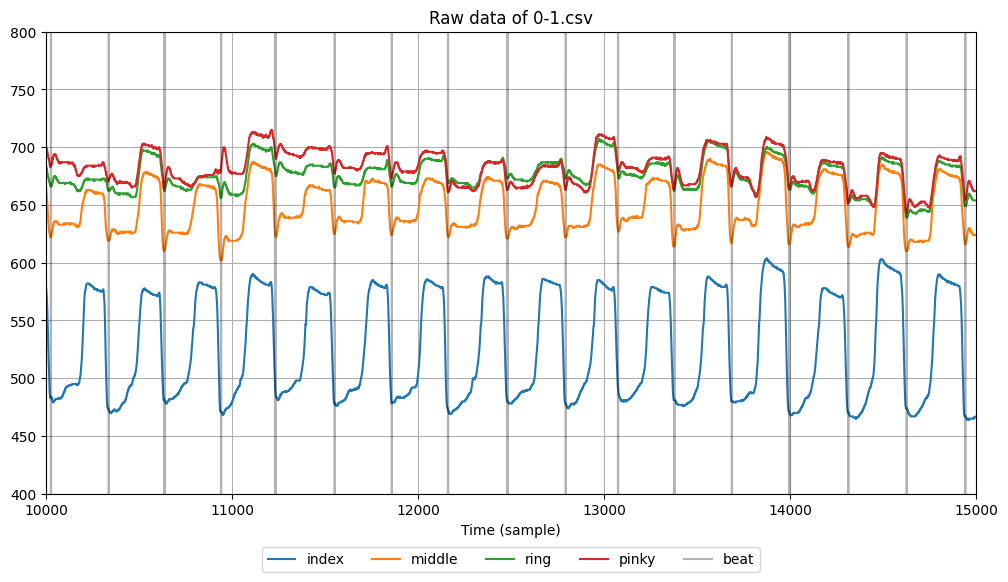

In [6]:
keys = ["index","middle","ring","pinky"]

# get x-axis in seconds
startTime = int(df.iloc[0,1])
endTime = int(df.iloc[-1,1])
x = np.linspace(0, endTime-startTime, df.shape[0])

# get peaks
accX = df['accX'].to_numpy()
delta = 1200 # increase to reduce number of peaks/valleys detected
peaks, valleys = peakdet(accX, delta)
beats = np.zeros(accX.size)
for valley in valleys:
    idx = int(valley[0])
    beats[idx] = 2000

# print stats
print("Frequency: %.3f Hz" % (df.shape[0]/(endTime-startTime)))
print("Number of beats:", len(np.where(beats>0)[0]))

# plot data
plt.figure(figsize=(12, 6)) 
for key in keys:
    plt.plot(df[key].to_numpy(), label=key)
plt.plot(beats, color="k", alpha=0.3, label="beat")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.xlabel("Time (sample)")
plt.xlim(10000,15000)
plt.ylim((400,800))
plt.title("Raw data of " + FILE)
plt.grid()
plt.show()

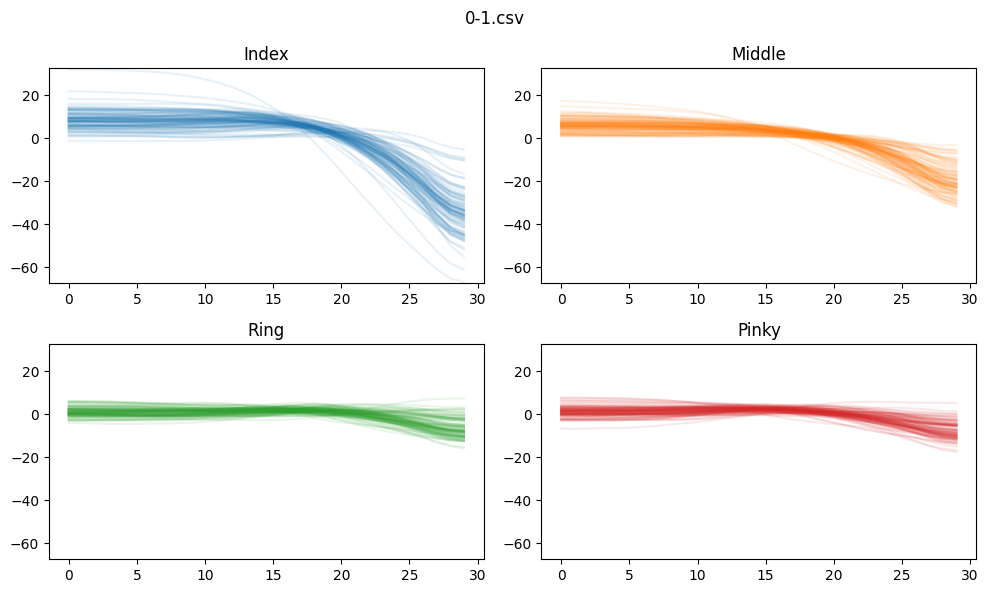

In [8]:
timestep = 30

# get indices of beats
ind = np.where(beats > 0)[0]
df_gesture = df.loc[:,["index","middle","ring","pinky"]].to_numpy()
X = np.empty([len(ind), timestep, 4])

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 6)

# split, filter and normalize data
alpha = 0.1
for i in range(len(ind)):
    idx = ind[i]
    gesture_data = df_gesture[idx-offset-timestep : idx-offset, :]
    filtered_data = uniform_filter1d(gesture_data, axis=0, size=5)
    for j in range(4):
        filtered_data[:,j] = filtered_data[:,j] - np.mean(filtered_data[:,j])
    X[i] = filtered_data
    ax[0,0].plot(filtered_data[:,0], color="C0", alpha=alpha)
    ax[0,1].plot(filtered_data[:,1], color="C1", alpha=alpha)
    ax[1,0].plot(filtered_data[:,2], color="C2", alpha=alpha)
    ax[1,1].plot(filtered_data[:,3], color="C3", alpha=alpha)
        
ymin = min(X.flatten()) - 0.5
ymax = max(X.flatten()) + 0.5

ax[0,0].set_title("Index")
ax[0,1].set_title("Middle")
ax[1,0].set_title("Ring")
ax[1,1].set_title("Pinky")
for a in ax.flatten():
    a.set_ylim((ymin, ymax))
plt.suptitle(FILE)
plt.tight_layout()
plt.show()

# Create Combined Dataset
Code to actually create the combined dataset. DataFrame has 2000 rows (samples) and 5 columns: index, middle, ring, pinky and label. Labels contain strings representing gesture transitions (e.g. 0-1) and the data samples are lists of 30 samples each.

In [14]:
def create_dataset():
    DATA_PATH = "../data/"
    NUM_BEATS = 100
    timestep = 30
    offset = 15 # number of samples before beat to take samples

    files = []
    for filename in os.listdir(DATA_PATH):
        f = os.path.join(DATA_PATH, filename)
        files.append(f)

    data = {
        "index": [],
        "middle": [],
        "ring": [],
        "pinky": [],
        "label": []
    }
    for i in range(len(files)):
        file = files[i]

        # create dataframe
        df = pd.read_csv(file, index_col=0)

        # get gesture
        gesture = df.iloc[0,0]

        # get beats indices
        accX = df['accX'].to_numpy()
        delta = 1000
        _, valleys = peakdet(accX, delta)
        num_beats = valleys.shape[0]
        # vary delta to ensure there are 100 valleys
        while num_beats != NUM_BEATS:
            delta += 100
            _, valleys = peakdet(accX, delta)
            num_beats = valleys.shape[0]
        beats = np.zeros(accX.size)
        for valley in valleys:
            idx = int(valley[0])
            beats[idx] = 1

        # get indices of beats
        ind = np.where(beats > 0)[0]
        df_gesture = df.loc[:,["index","middle","ring","pinky"]].to_numpy()    
        print("%s: %d beats" % (gesture, len(ind)))

        # split, filter and normalize data
        for j in range(len(ind)):
            idx = ind[j]
            gesture_data = df_gesture[idx-offset-timestep : idx-offset, :]
            filtered_data = uniform_filter1d(gesture_data, axis=0, size=10)
            for k in range(4):
                filtered_data[:,k] = filtered_data[:,k] - np.mean(filtered_data[:,k])
            data["index"].append(list(filtered_data[:,0]))
            data["middle"].append(list(filtered_data[:,1]))
            data["ring"].append(list(filtered_data[:,2]))
            data["pinky"].append(list(filtered_data[:,3]))
            data["label"].append(gesture)

    final_df = pd.DataFrame(data)
    return final_df

In [15]:
final_df = create_dataset()
final_df.to_csv("data.csv")

2-0: 100 beats
4-1: 100 beats
0-3: 100 beats
2-3: 100 beats
4-2: 100 beats
1-0: 100 beats
1-4: 100 beats
3-4: 100 beats
0-2: 100 beats
4-3: 100 beats
2-4: 100 beats
2-1: 100 beats
3-2: 100 beats
0-1: 100 beats
0-4: 100 beats
3-0: 100 beats
4-0: 100 beats
3-1: 100 beats
1-3: 100 beats
1-2: 100 beats
